In [149]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import random
# from shapely.geometry import Point
import copy
import time
import bisect
from scipy.stats import rankdata
from scipy import optimize as opt

In [ ]:
# NOTES
# Distance ranking: make sure in the grid view that equal distances give equal ranking
 # (Same for orientation rankings)

In [204]:
geodata = gpd.read_file('./Data/LADs.geojson').to_crs('epsg:27700')
# geodata = geodata[['E09' in c for c in geodata['LAD20CD']]][['LAD20CD', 'LAD20NM', 'geometry']]
geodata = geodata[['W' in c for c in geodata['LAD20CD']]][['LAD20CD', 'LAD20NM', 'geometry']]
geodata['dummy'] = geodata['geometry'].apply(lambda g: 1)
geodata['centroid'] = geodata.centroid

geo_list = geodata['LAD20CD'].values # Definitive list with definitive order of geometry codes
name_list = geodata['LAD20NM'].values

geo_to_index_lookup = {}
geo_to_name_lookup = {}
index_to_geo_lookup = {}
index_to_name_lookup = {}
for num, g, name in zip(range(len(geo_list)), geo_list, name_list):
    geo_to_index_lookup[g] = num
    geo_to_name_lookup[g] = name
    index_to_geo_lookup[num] = g
    index_to_name_lookup[num] = name

<AxesSubplot:>

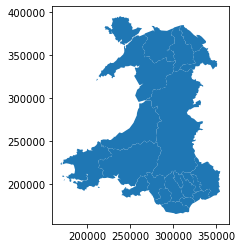

In [45]:
geodata.plot()

In [46]:
geodata

,LAD20CD,LAD20NM,geometry,dummy,centroid
357,W06000001,Isle of Anglesey,"POLYGON ((240000.004 394577.908, 240445.514 39...",1,POINT (241835.228 379233.676)
358,W06000002,Gwynedd,"MULTIPOLYGON (((267978.708 372366.304, 270868....",1,POINT (264136.399 334667.737)
359,W06000003,Conwy,"POLYGON ((299724.870 380889.607, 300371.113 37...",1,POINT (284072.324 361552.108)
360,W06000004,Denbighshire,"POLYGON ((324414.214 353387.707, 323145.711 35...",1,POINT (309507.880 355562.623)
361,W06000005,Flintshire,"MULTIPOLYGON (((313293.515 382786.601, 315287....",1,POINT (322547.437 368615.133)
362,W06000006,Wrexham,"POLYGON ((351298.712 343127.004, 350716.010 34...",1,POINT (331695.185 344175.768)
363,W06000008,Ceredigion,"POLYGON ((279749.210 249226.602, 277768.013 24...",1,POINT (258559.569 263733.729)
364,W06000009,Pembrokeshire,"MULTIPOLYGON (((216364.016 243983.404, 217396....",1,POINT (201337.424 221180.436)
365,W06000010,Carmarthenshire,"POLYGON ((279749.210 249226.602, 282307.116 24...",1,POINT (251556.904 225139.754)
366,W06000011,Swansea,"MULTIPOLYGON (((262123.115 210278.302, 264479....",1,POINT (258170.595 195828.191)


In [47]:
def make_df_array(row_labels, col_labels, values):
    
    dtype = values.dtype
    array = np.zeros((len(geo_list), len(geo_list)), dtype=dtype)
    
    for row_lab, col_lab, value in zip(row_labels, col_labels, values):
        array[geo_to_index_lookup[row_lab], geo_to_index_lookup[col_lab]] = value
            
    return array



# Identify which geometries are neighbours

g_copygeo = copy.copy(geodata)
g_copygeo['geocopy'] = g_copygeo.geometry

# Find all geometries which touch each other
neighbours = g_copygeo.sjoin(g_copygeo, how='inner', predicate='touches')
neighbours = neighbours.loc[neighbours['LAD20CD_left']!=neighbours['LAD20CD_right']]

# Find the length of the border as a fraction of the left geometry's total border
neighbours['intersection'] = neighbours.apply(lambda row: row['geocopy_left'].intersection(row['geocopy_right']), axis=1)
neighbours['weight'] = neighbours.apply(lambda row: row['intersection'].length/row['geocopy_left'].length, axis=1)

neighbours = neighbours[['LAD20CD_left', 'LAD20CD_right', 'weight']]

neighbours_array = make_df_array(neighbours['LAD20CD_left'].values, neighbours['LAD20CD_right'].values, neighbours['weight'].values)

/home/tpeterken/anaconda3/envs/AutoCartogram/lib/python3.10/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/home/tpeterken/anaconda3/envs/AutoCartogram/lib/python3.10/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/home/tpeterken/anaconda3/envs/AutoCartogram/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  numbe

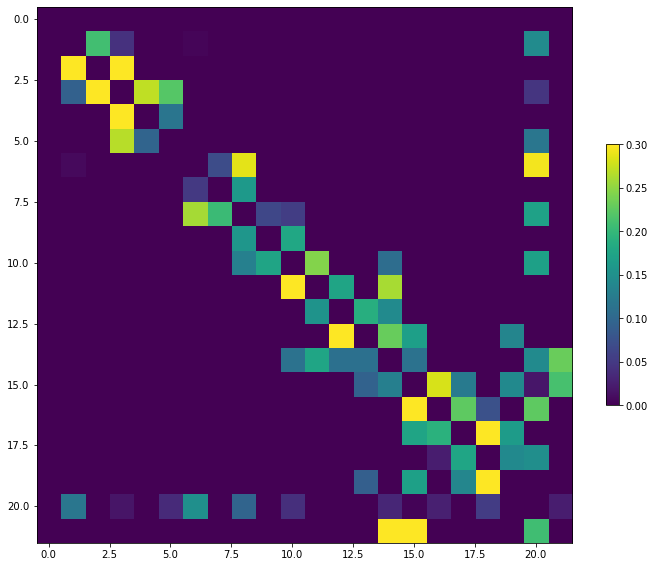

In [48]:
f, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(neighbours_array, vmax=0.3)
plt.colorbar(im, shrink=0.4)

In [50]:
# Measure the distance between each pair of geometries

def angle_between(loca, locb):
    xa, ya = loca.xy
    xb, yb = locb.xy    
    return np.arctan2(yb[0]-ya[0], xb[0]-xa[0])

crossjoin = geodata.merge(geodata, how='inner', on='dummy', suffixes=('_left', '_right'))
crossjoin = crossjoin.loc[crossjoin['LAD20CD_left']!=crossjoin['LAD20CD_right']]
crossjoin['distance'] = crossjoin.apply(lambda row: row['geometry_left'].distance(row['geometry_right']), axis=1)
crossjoin['target_distance_rank'] = crossjoin.groupby('LAD20CD_left')['distance'].rank()
crossjoin['target_angle'] = crossjoin.apply(lambda row: angle_between(row['centroid_left'], row['centroid_right']), axis=1)
distance_ranking = crossjoin[['LAD20CD_left', 'LAD20CD_right', 'target_distance_rank', 'target_angle']]

distance_array = make_df_array(distance_ranking['LAD20CD_left'].values, distance_ranking['LAD20CD_right'], distance_ranking['target_distance_rank'].values)
angle_array = make_df_array(distance_ranking['LAD20CD_left'].values, distance_ranking['LAD20CD_right'], distance_ranking['target_angle'].values)

In [51]:
distance_ranking

,LAD20CD_left,LAD20CD_right,target_distance_rank,target_angle
1,W06000001,W06000002,1.0,-1.106822
2,W06000001,W06000003,2.0,-0.396460
3,W06000001,W06000004,3.0,-0.336486
4,W06000001,W06000005,4.0,-0.130809
5,W06000001,W06000006,6.0,-0.371977
...,...,...,...,...
478,W06000024,W06000019,4.0,0.220886
479,W06000024,W06000020,7.0,-0.237013
480,W06000024,W06000021,9.0,0.065829
481,W06000024,W06000022,10.0,-0.597980


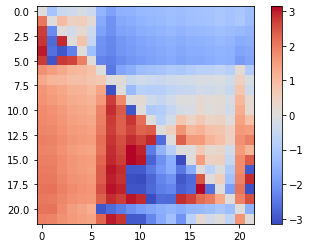

In [52]:
im = plt.imshow(angle_array, cmap='coolwarm')
plt.colorbar(im)

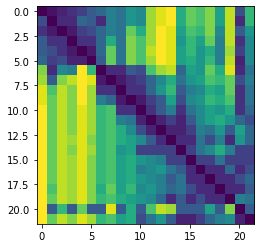

In [53]:
plt.imshow(distance_array)

In [54]:
# Measure the north-south and east-west ranking of all 

orientation_ranking = copy.copy(geodata)[['LAD20CD', 'centroid']]
orientation_ranking['x'] = orientation_ranking['centroid'].apply(lambda c: c.xy[0][0])
orientation_ranking['y'] = orientation_ranking['centroid'].apply(lambda c: c.xy[1][0])
orientation_ranking['EW'] = orientation_ranking['x'].rank()
orientation_ranking['NS'] = orientation_ranking['y'].rank()
orientation_ranking = orientation_ranking[['LAD20CD', 'EW', 'NS']]

northsouth_vector = [orientation_ranking[orientation_ranking['LAD20CD']==g]['NS'].values[0] for g in geo_list]
westeast_vector = [orientation_ranking[orientation_ranking['LAD20CD']==g]['EW'].values[0] for g in geo_list]

In [138]:
number_of_geographies = len(geodata)

max_number_of_spaces = 2 # in multiples of the number of input geographies

neighbour_distance_factor = 8
packing_factor = 1
orientation_factor = 70

initial_axis_ratio = (geodata.total_bounds[3]-geodata.total_bounds[1])/(geodata.total_bounds[2]-geodata.total_bounds[0])

In [114]:
def make_integer_positions(position_list, empty_list):
    # Turns a list of values into a list of integer values depending on the values' ranking
    all_positions = np.concatenate([position_list, empty_list])
    ranks = rankdata(all_positions)
    return np.array(ranks, dtype=int)[:len(position_list)]-1


def make_grid(
    requested_number, # Target number of positions in the grid
    axis_ratio, # Target axis ratio
    actual_number=number_of_geographies, # Number of geographies which have to fit in the grid
    min_spaces=0, # Minimum multiple of actual_number which can be occupied by empties
    max_spaces=max_number_of_spaces # Maximum multiple of actual_number which can be occupied by empties
):    
    
    requested_number = (min_spaces+1)*actual_number if (min_spaces+1)*actual_number > requested_number else requested_number
    requested_number = (max_spaces+1)*actual_number if (max_spaces+1)*actual_number < requested_number else requested_number
    
    # Define basic naive dimensions
    X_size = int(np.round(np.sqrt(requested_number/axis_ratio)))
    Y_size = int(np.round(axis_ratio*X_size))    
    grid_size = X_size*Y_size
    
    # Adjust the X-size up or down to accommodate min_spaces and max_spaces
    while grid_size <= (min_spaces+1)*actual_number:
        X_size = X_size+1
        grid_size = X_size*Y_size
    while grid_size >= (max_spaces+1)*actual_number:
        X_size = X_size-1
        grid_size = X_size*Y_size
    
    # Return the final grid dimensions
    return (X_size, Y_size)


def number_of_empties(grid_dims, actual_number=number_of_geographies):
    return np.product(grid_dims)-actual_number

def make_positions_2d(grid_dims, position_list):
    return np.unravel_index(position_list, grid_dims, order='F')

def pad_array(array, num_empties):
    return np.pad(array, [0, num_empties])

def get_distance_matrix(x_list, y_list):
    a = [rankdata([np.sqrt((x1-x2)**2 + (y1-y2)**2) for x1,y1 in zip(x_list, y_list)])-1 for x2,y2 in zip(x_list, y_list)]
    return np.array(a)

def orientation_order(x_list, y_list):    
    return rankdata(y_list)-1, rankdata(x_list)-1 # NS, EW
    
    
# def compare_


In [147]:
initial_positions = np.random.random(number_of_geographies*(1+max_number_of_spaces))

In [152]:
initial_positions

array([0.46981318, 0.04041864, 0.28040809, 0.9728998 , 0.10111441,
       0.46865376, 0.77365415, 0.5660805 , 0.93248192, 0.49781841,
       0.6986696 , 0.77869222, 0.04131802, 0.37719635, 0.62592112,
       0.85132815, 0.74042333, 0.01605815, 0.65791745, 0.83361331,
       0.05363617, 0.03248963, 0.86262015, 0.5596029 , 0.01040909,
       0.88650361, 0.58345929, 0.86253756, 0.16323402, 0.19921335,
       0.48959379, 0.85381029, 0.62553584, 0.03686873, 0.24800242,
       0.7819515 , 0.76159855, 0.254131  , 0.72863959, 0.85746694,
       0.9086517 , 0.40616717, 0.97743062, 0.04006976, 0.13238994,
       0.77980656, 0.00177895, 0.34043829, 0.84922563, 0.38360239,
       0.51930628, 0.45046035, 0.23987005, 0.39788435, 0.64185644,
       0.53206187, 0.16329349, 0.9075717 , 0.57257744, 0.79662626,
       0.42813734, 0.770885  , 0.13459029, 0.69934599, 0.58702585,
       0.4146403 ])

In [172]:
def get_metric_vector(grid_locations):
    distance_matrix = get_distance_matrix(*grid_locations)
    orientation_ordering = orientation_order(*grid_locations)

    neighbour_metric_matrix = distance_matrix*neighbours_array
    neighbour_metric_vector = neighbour_metric_matrix.sum(axis=1)

    packing_metric_matrix = distance_matrix**2
    packing_metric_vector = packing_metric_matrix.sum(axis=1)

    orientation_metric_NS = (orientation_ordering[0]-northsouth_vector)**2
    orientation_metric_EW = (orientation_ordering[1]-westeast_vector)**2
    orientation_metric_vector = orientation_metric_NS+orientation_metric_EW
    
    metric_vector = (neighbour_distance_factor*neighbour_metric_vector) + (packing_factor*packing_metric_vector) + (orientation_factor*orientation_metric_vector)
    
    return metric_vector


def get_total_metric(total_grid_spaces, axis_ratio, all_positions):
    
    occupied_positions = all_positions[:number_of_geographies]
    empty_positions = all_positions[number_of_geographies:]
    
    grid_size = make_grid(total_grid_spaces, axis_ratio)
    number_empties = number_of_empties(grid_size)
    
    int_positions = make_integer_positions(occupied_positions, empty_positions[:number_empties])
    grid_locations = make_positions_2d(grid_size, int_positions)

    metric_vector = get_metric_vector(grid_locations)
    
    return metric_vector, grid_locations


def function_to_minimize(args):
    return get_total_metric(args[0], args[1], args[2:])[0].sum()

In [197]:
initial_args = np.concatenate([[1.5*number_of_geographies], [initial_axis_ratio], initial_positions])
arg_bounds = np.concatenate([
    [(number_of_geographies, (1+max_number_of_spaces)*number_of_geographies)],
    [(0.5*initial_axis_ratio, 2*initial_axis_ratio)],
    [(0,1)]*len(initial_positions)
])

In [ ]:
# o = opt.minimize(function_to_minimize, initial_args, bounds=arg_bounds, options={'maxiter':100000})

start_time = time.time()
o = opt.dual_annealing(function_to_minimize, arg_bounds, x0=initial_args, maxiter=1000)
end_time = time.time()

print(str(np.round((end_time-start_time)/60, decimals=1))+' minutes')

In [ ]:
initial_metric_vector, in_positions = get_total_metric(initial_args[0], initial_args[1], initial_args[2:])
final_metric_vector, f_positions = get_total_metric(o.x[0], o.x[1], o.x[2:])

In [ ]:
import matplotlib as mpl

cmap = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin=np.min([initial_metric_vector.min(), final_metric_vector.min()]), vmax=np.min([initial_metric_vector.max(), final_metric_vector.max()]))

f, axs = plt.subplots(figsize=(grid_size[0]*2, grid_size[1]), ncols=2)
_ = [ax.axis('equal') for ax in axs]
_ = [ax.axis('off') for ax in axs]

# markers = ['o']*number_of_geographies+['.']*number_empties
for geocode, v, x, y in zip(geo_list, initial_metric_vector, *in_positions):
    c = cmap(norm(v))
    axs[0].plot(x, y, 'o', color=c)
    axs[0].annotate(geo_to_name_lookup[geocode], xy=(x,y-0.2), xytext=(0,0), textcoords="offset points", ha='center', va='center', size='small')
        
for geocode, v, x, y in zip(geo_list, final_metric_vector, *f_positions):
    c = cmap(norm(v))
    axs[1].plot(x, y, 'o', color=c)
    axs[1].annotate(geo_to_name_lookup[geocode], xy=(x,y-0.2), xytext=(0,0), textcoords="offset points", ha='center', va='center', size='small')